In [26]:
import numpy as np
import matplotlib.pyplot as plt
import csv, datetime
import pandas as pd
import matplotlib.dates as mdates
import os, sys


def MakeDataFromText(filepath):
    """
    Helper function to parse text files in IFM proprietary format.
    """
    with open(filepath, 'r') as file:
        reader = csv.reader(file)

        db = dict()                          # Dictionary that will hold k,v pairs of 
        recent_EPC = ''                      # The most recent EPC that was read, and data is being assigned to
        Time_Or_Data = True                  # Time is true, Data is false
        reached_24 = False

        for l in reader:                     # Iterate over entire text file
            line = l[0]                      # Each line only has one token, so we select it
            
            if len(line)==24:                # If it is an EPC
                db[line] = [[],[]]           # Create new k,v pair in database
                recent_EPC = line            # Current EPC to add to is selected
            
            elif line == '[':                # If start bracket, beginning to collect an array of data
                data = []

            elif line == ']':                # End bracket means end of data array
                if len(data)!=0:
                    if Time_Or_Data:
                        db[recent_EPC][0] = data
                        Time_Or_Data = False
                    else:
                        db[recent_EPC][1] = data
                        Time_Or_Data = True
                data = []

            elif line.count(":")==2:
                h,m,s = line.split(':')      # Parse timestamp into hours, minutes, seconds

                if int(h)==23:
                    reached_24 = True        # If end of day reached, must move to Day 2

                if reached_24 and int(h) < 12:
                    day=2
                else:
                    day=1

                data.append(datetime.datetime(1970, 2, day, int(h), int(m), int(s)))
            
            elif line ==' ':               # If blank space, then we skip to parse next line
                pass

            else:                          # If it is a data point
                try:
                    data.append(float(line))
                except:
                    pass                   # Error catching case just in case, so annoying errors don't crash program
    return db

rrr = MakeDataFromText("032323 test on 35C water/RSSI_22792.csv")
ttt = MakeDataFromText("032323 test on 35C water/tags_22792.csv")

temp = dict()
for d in [ ttt ]:
    for k,v in d.items():
        if k in temp: # if tag is already in dict
            for i in range(len(v[0])):
                if v[0][i] in temp[k]:
                    temp[k][v[0][i]].append(v[1][i])
                else:
                    temp[k][v[0][i]] = [v[1][i]]
        else:             # if tag is not in dict
            temp[k] = dict()
            for i in range(len(v[0])):
                temp[k][v[0][i]] = [v[1][i]]
for k,v in temp.items():
    for k2,v2 in v.items():
        temp[k][k2] = sum(v2)/len(v2)

rssi = dict()
for d in [ rrr ]:
    for k,v in d.items():
        if k in rssi: # if tag is already in dict
            for i in range(len(v[0])):
                if v[0][i] in rssi[k]:
                    rssi[k][v[0][i]].append(v[1][i])
                else:
                    rssi[k][v[0][i]] = [v[1][i]]
        else:             # if tag is not in dict
            rssi[k] = dict()
            for i in range(len(v[0])):
                rssi[k][v[0][i]] = [v[1][i]]
for k,v in rssi.items():
    for k2,v2 in v.items():
        rssi[k][k2] = sum(v2)/len(v2)

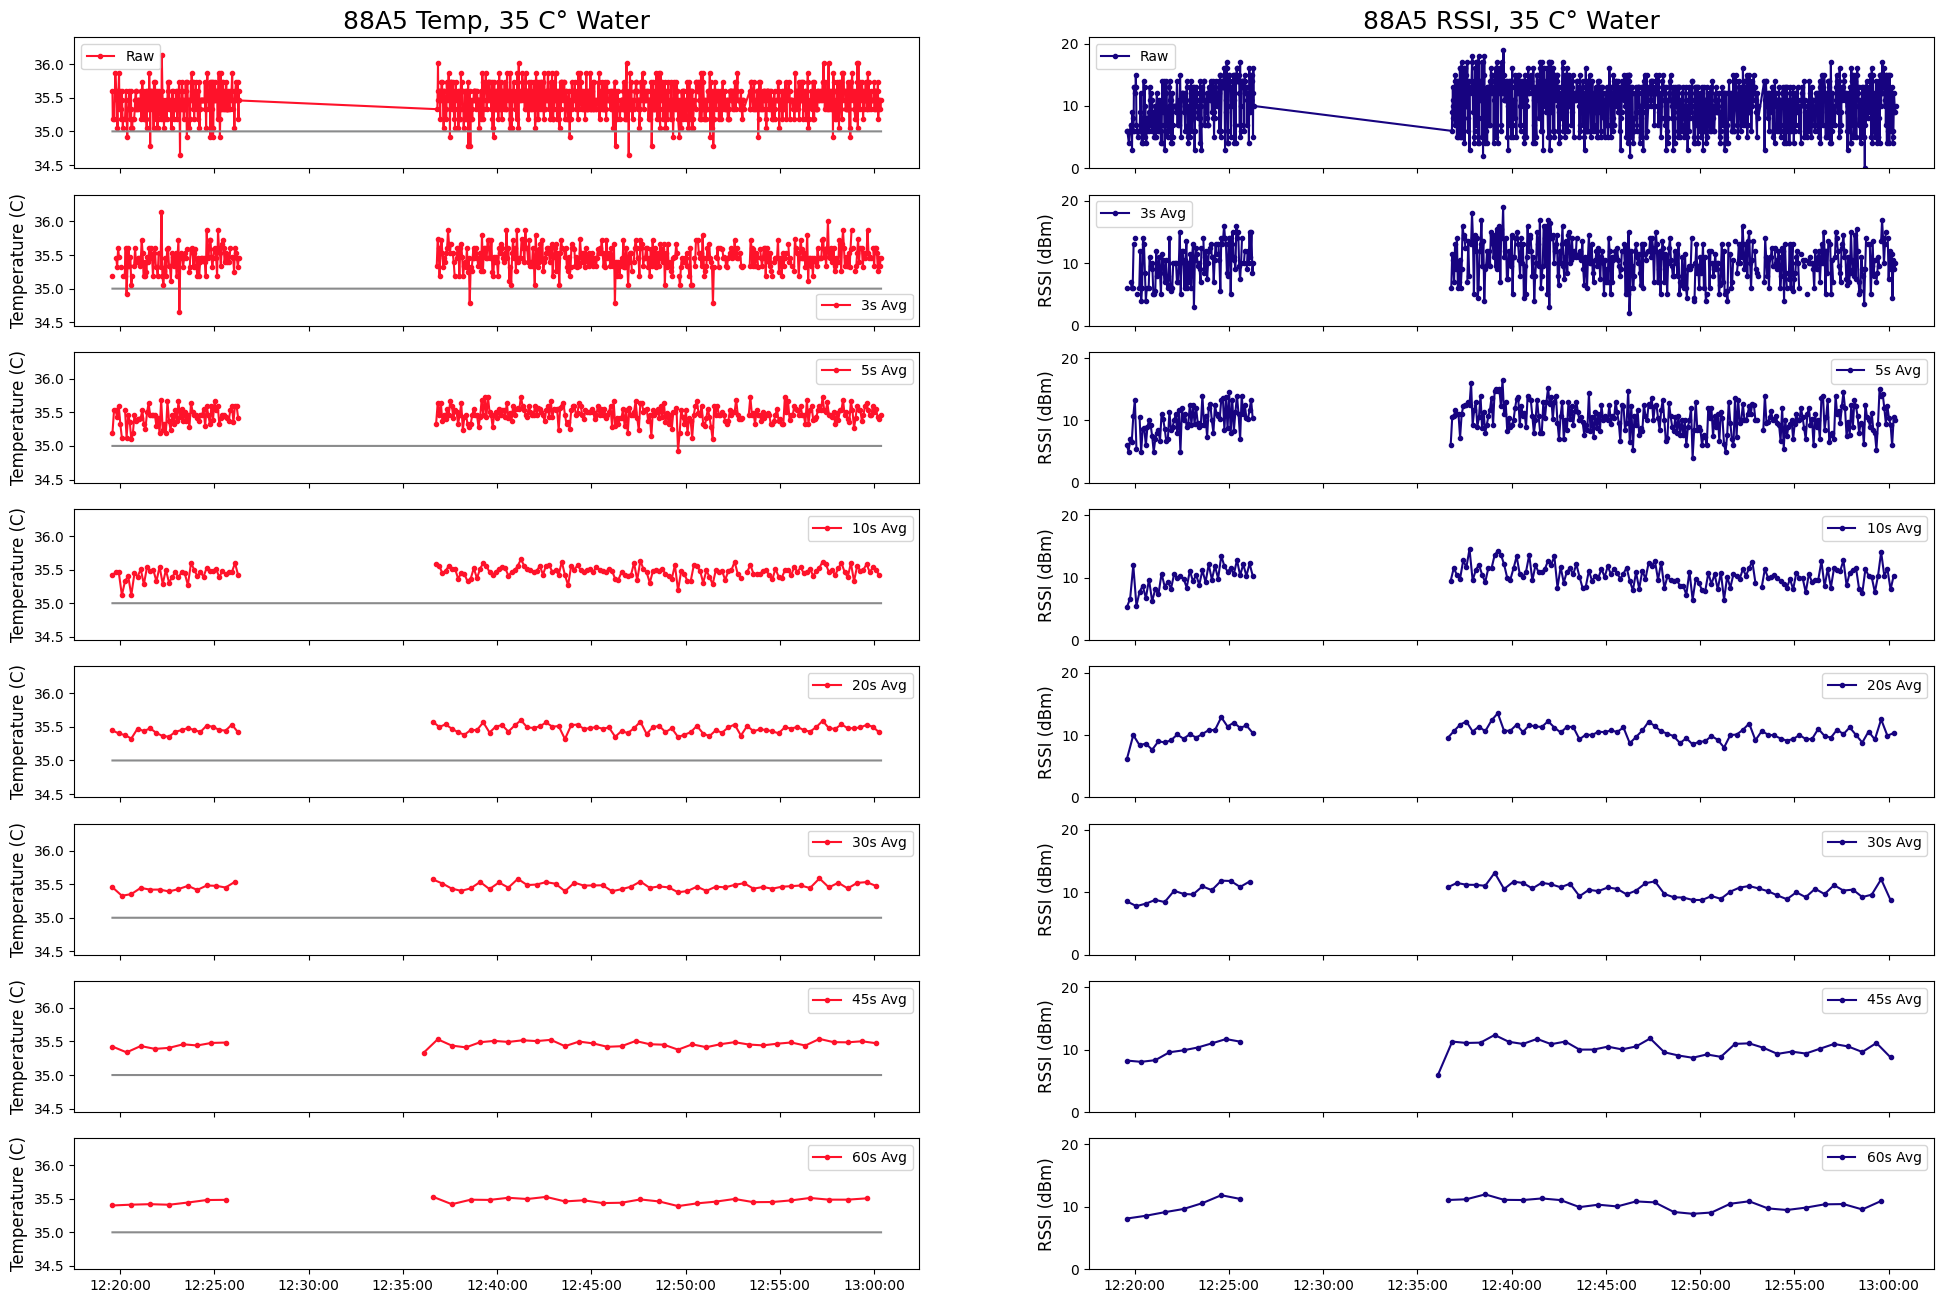

In [27]:
avg_temp = []
avg_rssi = []
times1 = []

fig, ax = plt.subplots(8, 2,figsize=(24, 16), sharex=True)

ax[0][0].xaxis.set_major_formatter( mdates.DateFormatter('%H:%M:%S') )

tempcolor = "#FE122A";
rssicolor = "#170380";

xlow, xhigh = 34.45, 36.4       # TEMP RANGE
ylow, yhigh = 0.0, 21.0         # RSSI RANGE

ax[0][0].set_ylim(xlow, xhigh)
ax[0][1].set_ylim(ylow, yhigh)

EPC = "88A5";

ax[0][0].set_title( EPC + " Temp, 35 C° Water", fontsize=18 )
ax[0][1].set_title( EPC + " RSSI, 35 C° Water", fontsize=18 )

row = 1
first = True
for clock in [ (3,1800), (5,1080), (10,540), (20,270), (30,180), (45,120), (60,90) ]:
    for k,v in temp.items():
        if k[-4:]==EPC:
            st = sorted( temp[k].items() )
            sr = sorted( rssi[k].items() )

            dt, tt = [ j[1] for j in st ], [ j[0] for j in st ]
            dr = [ j[1] for j in sr ]
            real = [35.0 for j in sr]

            if first:
                ax[0][0].plot( tt, dt, marker=".", label="Raw", color=tempcolor)
                ax[0][1].plot( tt, dr, marker=".", label="Raw", color=rssicolor)
                ax[0][0].legend()
                ax[0][1].legend()
                real = [35.0 for j in sr]
                ax[0][0].plot( tt, real, color="#8A8B8C")
                first = False
            
            avg_temp = []
            avg_rssi = []

            BEGIN = tt[0]
            times1 = [ BEGIN + datetime.timedelta(seconds=clock[0]*i) for i in range(clock[1]) ]

            for i in range(len(times1)-1):
                dt = [ j[1] for j in st if j[0]>times1[i] and j[0]<times1[i+1] ]
                dr = [ j[1] for j in sr if j[0]>times1[i] and j[0]<times1[i+1] ]

                avg_temp.append( np.mean(dt) )
                avg_rssi.append( np.mean(dr) )

            ax[row][0].plot( tt, real, color="#8A8B8C")

            ax[row][0].plot( times1[:-1], avg_temp, marker=".", label="{}s Avg".format(clock[0]), color=tempcolor)
            ax[row][1].plot( times1[:-1], avg_rssi, marker=".", label="{}s Avg".format(clock[0]), color=rssicolor)

            ax[row][0].legend()
            ax[row][1].legend()

            ax[row][0].set_ylim(xlow, xhigh)
            ax[row][1].set_ylim(ylow, yhigh)

            ax[row][0].set_ylabel("Temperature (C)", fontsize=12)
            ax[row][1].set_ylabel("RSSI (dBm)",      fontsize=12)

            row += 1